In [22]:
from pathlib import Path
import pandas as pd
import woodsort.helper_functions
import woodsort.nwb as nwb 
import pynapple as nap
import spikeinterface.full as si
import warnings


In [2]:
### SPECIFY PATHS ### 

data_path = Path('/home/avadher/Data/Adrian/')
session_name = 'H7113-250604'
meta_name = 'H7100_metadata.xlsx'
analyzer_name = session_name + '_analyzer_mountainsort5'
nwb_path = data_path / 'NWB' / session_name

session_path = list(data_path.rglob(session_name))[0]
analyzer_path = session_path / analyzer_name
lfp_path = session_path / 'continuous.lfp'

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [25]:
### LOAD DATA ###

metadata = nwb.io.read_metadata_excel(data_path / meta_name, session_name, print_output=True)
start_time = nwb.io.get_start_time(session_path)

# load tracking 
tracking = pd.read_csv(session_path / 'TrackingProcessed.csv',index_col=0, header=0)
pos = nap.TsdFrame(tracking[["x", "y"]])
hd = nap.Tsd(tracking['hd'])
epochs = pd.read_csv(session_path / 'EpochTimestamps.csv', header=0)

# load SpikeInterface analyzer
analyzer = si.load_sorting_analyzer(analyzer_path)


{'epoch': {'1': 'wake', '2': 'sleep', '3': 'wake_cue_rot'},
 'file': {'experiment_description': 'Reorientation in the head-direction system',
          'experimenter': 'Narayanan, Trisha',
          'institution': 'University of Edinburgh',
          'lab': 'Wood/Dudchenko lab',
          'name': 'H7113-250604',
          'protocol': 'day1',
          'session_description': 'Cue rotations (45, 90, 135, 180 deg)'},
 'probe': [{'description': '2x32-channels, 25 um channel spacing, implanted at 10 deg angle. '
                           'Channels sorted top to bottom of shank.',
            'id': 1,
            'location': 'left postsubiculum',
            'nshanks': 2,
            'step': 25,
            'type': 'Cambridge Neurotech H7 probe'}],
 'subject': {'dob': 250228, 'genotype': 'WT', 'line': 'Fmr1', 'sex': 'M', 'stock_id': 1906344}}

Start time from sync_messages.txt: 2025-06-04 14:46:12.720000+01:00
['Record Node 101#Acquisition_Board-100.Rhythm Data', 'Record Node 101#Acquisitio

In [6]:
### NWB ### 

#Create NWB file
nwbfile = nwb.convert.create_nwb_file(metadata, start_time)

# Add units
nwbfile = nwb.convert.add_spikeinterface_openephys(nwbfile, analyzer, merging_mode='soft')

# Add tracking
nwbfile = nwb.convert.add_tracking(nwbfile, pos, hd)

# Add epochs
nwbfile = nwb.convert.add_epochs(nwbfile, epochs, metadata)

# Save NWB file
nwb.convert.save_nwb_file(nwbfile, nwb_path, session_name)

# Load to check
rec = nwb.convert.load_nwb_file(nwb_path, session_name)


Creating NWB file and adding metadata...
Adding SpikeInterface units and metrics to the NWB file...
   location                                              group group_name  \
id                                                                          
0   unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          0   
1   unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          0   
2   unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          0   
3   unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          0   
4   unknown  0 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          0   
..      ...                                                ...        ...   
57  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          1   
58  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          1   
59  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1393121165...          1   
60  unknown  1 pynwb.ecephys.ElectrodeGroup at 0x1393

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

Index    rate      unit_name    quality    aggregation_key    coord_est_x    ...
-------  --------  -----------  ---------  -----------------  -------------  -----
0        5.42213   0            good       0                  16.14239       ...
1        3.32021   1            good       0                  2.05389        ...
2        7.78159   2            good       0                  -3.39946       ...
3        5.13221   3            good       0                  -8.9904        ...
4        0.94378   4            good       0                  -2.34179       ...
5        7.4454    5            good       0                  -1.34301       ...
6        1.45423   6            good       0                  12.36302       ...
...      ...       ...          ...        ...                ...            ...
80       3.32329   80           good       1                  234.13931      ...
81       1.46502   81           good       1                  218.32565      ...
82       2.14356   82     

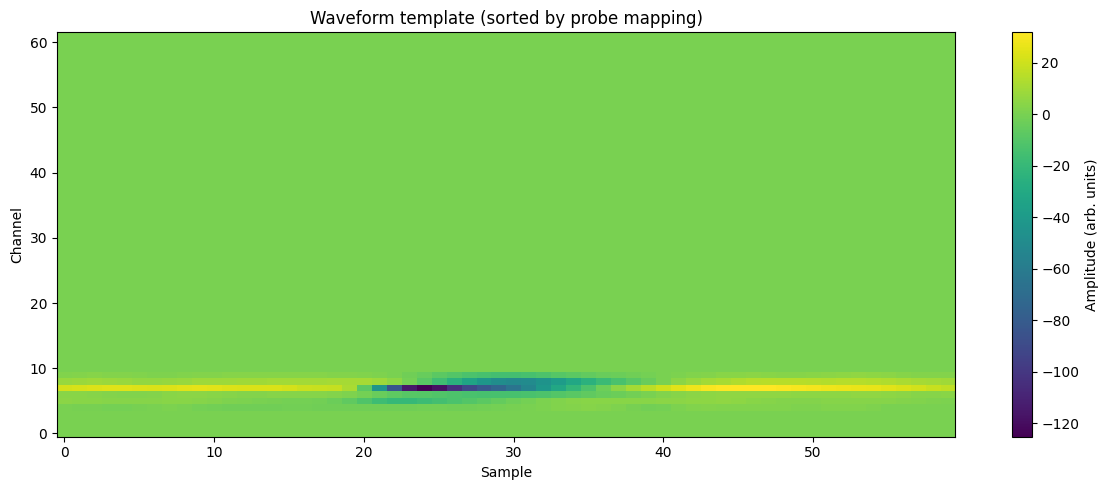

In [9]:
import matplotlib.pyplot as plt

print(rec['units'])

### GET ANATOMICALLY SORTED WAVEFORMS FROM NWB ### 

# get electrodes table 
electrodes_table = rec.nwb.electrodes.to_dataframe() # electrode_name is anatomical index (top-bottom shank-wise) 
#electrodes_table['electrode_name'] = electrodes_table['electrode_name'].astype(int) # make sure it's int - SpikeInterface sometimes turns them to strings
electrodes_table['channel_name'] = electrodes_table['channel_name'].str.replace('CH', '', regex=False).astype(int) - 1 # now channel_name is the dat file channel index (0-based)
# To sort the waveform anatomically by shank and then by the y coordinate
electrodes_table = electrodes_table.sort_values(by=['aggregation_key', 'rel_y'], ascending=[True, False])
sort_ix = electrodes_table.index.to_numpy().astype(int) # use index to sort waveforms anatomically 

# load waveform 
waveforms = analyzer.get_extension("templates").get_data()
cell_number = 1  # cell 75 is obvious to track down 
wf = waveforms[cell_number,:,sort_ix] # waveforms are arranged according to a cryptic device_contact_index in SpikeInterface that gets propagated as index here

# plot waveform - it should be spatially localized 
plt.figure(figsize=(12, 5))
im = plt.imshow(wf, aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (sorted by probe mapping)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()



In [9]:
print(rec.nwb.devices['Device'])

Device pynwb.device.Device at 0x136600459363088
Fields:
  description: Ecephys probe. Automatically generated.



In [12]:
p = analyzer.get_probe()
p.contact_ids

array(['13', '7', '23', '1', '29', '3', '12', '18', '14', '24', '8', '22',
       '2', '28', '4', '27', '21', '10', '16', '0', '26', '6', '20', '31',
       '30', '25', '5', '11', '19', '17', '48', '52', '44', '38', '58',
       '32', '33', '57', '43', '63', '37', '53', '47', '36', '42', '54',
       '46', '35', '59', '41', '61', '39', '55', '45', '49', '60', '51',
       '62', '34', '56', '40', '50'], dtype='<U2')